<a href="https://colab.research.google.com/github/vikasrkarjigi/ML_ElasticNet_Regularization/blob/main/ElasticNet_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

R2 Score (No Regularization) - Train: 0.8206194483296296, Test: 0.8666382520148099
R2 Score (Lasso (L1)) - Train: 0.8278847156694062, Test: 0.8708716426348195
R2 Score (Ridge (L2)) - Train: 0.8258692409649343, Test: 0.8678973202478635

Elastic Net Scores for Different Alphas and L1 Ratios:
Alpha: 0.0001, L1 Ratio: 0.1, Train R2: 0.8279, Test R2: 0.8709
Alpha: 0.0001, L1 Ratio: 0.3, Train R2: 0.8279, Test R2: 0.8709
Alpha: 0.0001, L1 Ratio: 0.5, Train R2: 0.8279, Test R2: 0.8709
Alpha: 0.0001, L1 Ratio: 0.7, Train R2: 0.8279, Test R2: 0.8709

Alpha: 0.0004, L1 Ratio: 0.1, Train R2: 0.8279, Test R2: 0.8709
Alpha: 0.0004, L1 Ratio: 0.3, Train R2: 0.8279, Test R2: 0.8709
Alpha: 0.0004, L1 Ratio: 0.5, Train R2: 0.8279, Test R2: 0.8709
Alpha: 0.0004, L1 Ratio: 0.7, Train R2: 0.8279, Test R2: 0.8709

Alpha: 0.0013, L1 Ratio: 0.1, Train R2: 0.8279, Test R2: 0.8709
Alpha: 0.0013, L1 Ratio: 0.3, Train R2: 0.8279, Test R2: 0.8709
Alpha: 0.0013, L1 Ratio: 0.5, Train R2: 0.8279, Test R2: 0.8709
Alp

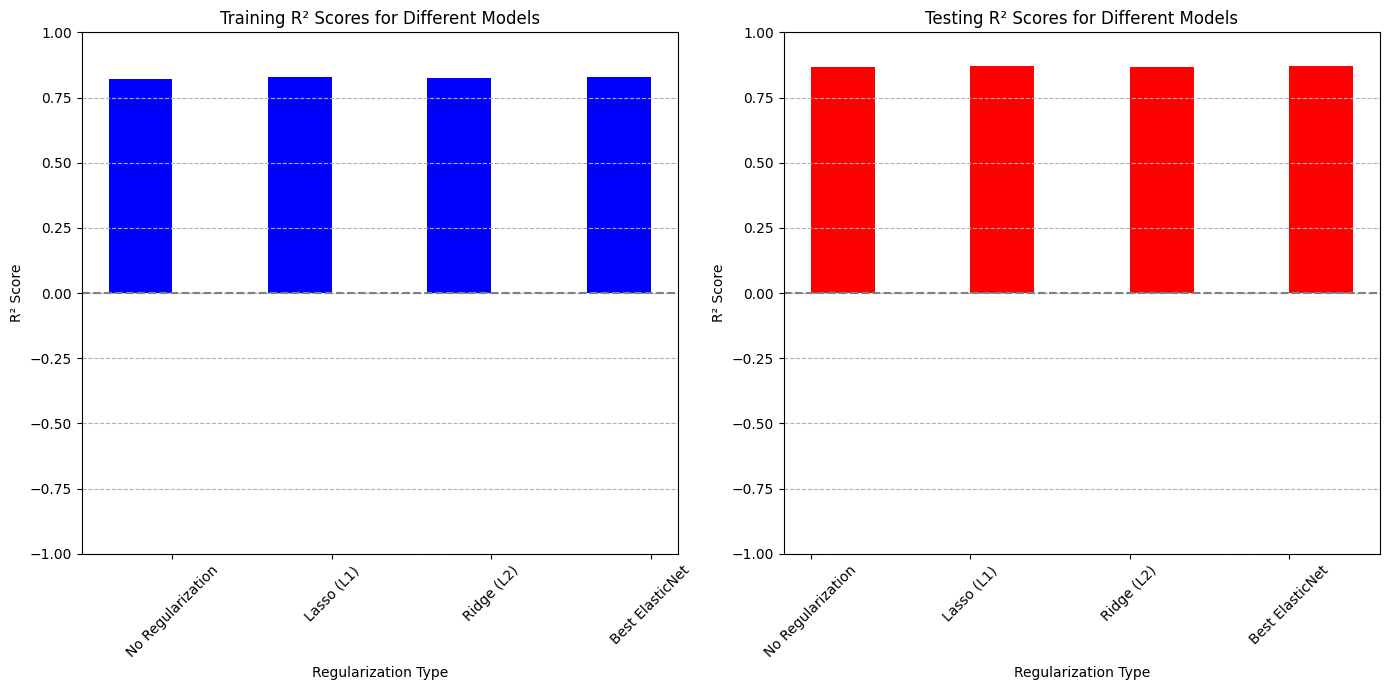

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the Ames Housing dataset
data = pd.read_csv('/content/sample_data/AmesHousing.csv')

# Drop irrelevant columns and handle missing data
target = 'SalePrice'
features = data.drop(['Order', 'PID', 'SalePrice'], axis=1)

# Fill missing values with median for numeric columns, and mode for categorical columns
features = features.fillna(features.median(numeric_only=True))
features = features.fillna(features.mode().iloc[0])

# Convert categorical columns to dummy variables (one-hot encoding)
features = pd.get_dummies(features, drop_first=True)

# Split the data into training and testing sets manually
train_size = int(0.8 * len(features))
X_train = features[:train_size]
X_test = features[train_size:]
y_train = data[target].values[:train_size]
y_test = data[target].values[train_size:]

# Standardize only numeric columns
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

mean = X_train_numeric.mean(axis=0)
std = X_train_numeric.std(axis=0)

X_train_scaled = (X_train_numeric - mean) / std
X_test_scaled = (X_test_numeric - mean) / std

# Base class for regression models
class BaseRegression:
    def __init__(self):
        self.theta = None

    def fit(self, X, y):
        raise NotImplementedError("Fit method not implemented!")

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.theta)

    def r2_score(self, y_true, y_pred):
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)
        return 1 - (ss_residual / ss_total)

# Linear Regression without Regularization
class LinearRegressionNoReg(BaseRegression):
    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Adding bias term
        self.theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

# Regularized Regression with L1 (Lasso) and L2 (Ridge)
class RegularizedRegression(BaseRegression):
    def __init__(self, alpha=0.01, l1_ratio=0):
        super().__init__()
        self.alpha = alpha
        self.l1_ratio = l1_ratio

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        m, n = X_b.shape
        self.theta = np.zeros(n)
        for _ in range(1000):  # Fixed iterations
            for j in range(n):
                X_j = X_b[:, j]
                residual = y - X_b.dot(self.theta) + self.theta[j] * X_j
                rho = X_j.T.dot(residual)
                if j == 0:  # Intercept
                    self.theta[j] = rho / m
                else:
                    # Regularization terms
                    l1_term = self.l1_ratio * self.alpha
                    l2_term = (1 - self.l1_ratio) * self.alpha
                    self.theta[j] = self._soft_threshold(rho / m, l1_term) / (1 + l2_term)

    def _soft_threshold(self, rho, lambda_val):
        return np.sign(rho) * max(0, abs(rho) - lambda_val)

# ElasticNet Regression Class
class ElasticNetRegression(RegularizedRegression):
    def __init__(self, alpha=0.01, l1_ratio=0.5):
        super().__init__(alpha, l1_ratio)

# Function to perform grid search for ElasticNet
def grid_search_elastic_net(X, y, alphas, l1_ratios):
    best_score = -np.inf
    best_params = None
    best_model = None
    results = []  # To store scores for each alpha

    for alpha in alphas:
        for l1_ratio in l1_ratios:
            model = ElasticNetRegression(alpha=alpha, l1_ratio=l1_ratio)
            model.fit(X, y)
            y_train_pred = model.predict(X)
            y_test_pred = model.predict(X_test_scaled)
            train_score = model.r2_score(y, y_train_pred)
            test_score = model.r2_score(y_test, y_test_pred)

            results.append((alpha, l1_ratio, train_score, test_score))

            if test_score > best_score:
                best_score = test_score
                best_params = (alpha, l1_ratio)
                best_model = model

    return best_model, best_params, best_score, results

# Initialize models
models = {
    "No Regularization": LinearRegressionNoReg(),
    "Lasso (L1)": RegularizedRegression(alpha=0.1, l1_ratio=1),
    "Ridge (L2)": RegularizedRegression(alpha=0.1, l1_ratio=0),
}

r2_train_scores = {}
r2_test_scores = {}

# Train, predict, and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    r2_train_scores[name] = model.r2_score(y_train, y_train_pred)
    r2_test_scores[name] = model.r2_score(y_test, y_test_pred)
    print(f"R2 Score ({name}) - Train: {r2_train_scores[name]}, Test: {r2_test_scores[name]}")

# Define specific L1 ratios for grid search
alphas = np.logspace(-4, 1, 10)  # Alpha values from 0.0001 to 10
l1_ratios = [0.1, 0.3, 0.5, 0.7]  # Selected L1 ratio values

# Perform grid search for ElasticNet
best_model, best_params, best_score, elastic_net_results = grid_search_elastic_net(X_train_scaled, y_train, alphas, l1_ratios)

# Print R2 scores for each alpha and l1_ratio with spacing for readability
print("\nElastic Net Scores for Different Alphas and L1 Ratios:")
last_alpha = None  # Track the last alpha value

for alpha, l1_ratio, train_score, test_score in elastic_net_results:
    # Print a newline if the alpha changes to improve readability
    if last_alpha is not None and last_alpha != alpha:
        print()  # Print a blank line to separate different alpha values

    print(f"Alpha: {alpha:.4f}, L1 Ratio: {l1_ratio}, Train R2: {train_score:.4f}, Test R2: {test_score:.4f}")
    last_alpha = alpha  # Update the last alpha value

# Fit the best ElasticNet model on the training and test set
best_model.fit(X_train_scaled, y_train)
y_train_best_elastic = best_model.predict(X_train_scaled)
y_test_best_elastic = best_model.predict(X_test_scaled)

# Get R2 scores for the best ElasticNet model
best_r2_train_score = best_model.r2_score(y_train, y_train_best_elastic)
best_r2_test_score = best_model.r2_score(y_test, y_test_best_elastic)

# Output best ElasticNet model results
print(f"\nBest ElasticNet Model: alpha={best_params[0]}, l1_ratio={best_params[1]}, R2 Score - Train: {best_r2_train_score}, Test: {best_r2_test_score}")

# Plotting R2 scores for all models
model_names = list(r2_train_scores.keys()) + ['Best ElasticNet']
r2_train_scores_values = list(r2_train_scores.values()) + [best_r2_train_score]
r2_test_scores_values = list(r2_test_scores.values()) + [best_r2_test_score]

x = np.arange(len(model_names))  # the label locations

plt.figure(figsize=(14, 7))

# Plotting training R2 scores
plt.subplot(1, 2, 1)
plt.bar(x - 0.2, r2_train_scores_values, width=0.4, label='Training R² Score', color='blue')
plt.axhline(0, color='grey', linestyle='--')
plt.xticks(x, model_names, rotation=45)
plt.xlabel('Regularization Type')
plt.ylabel('R² Score')
plt.title('Training R² Scores for Different Models')
plt.ylim(-1, 1)
plt.grid(axis='y', linestyle='--')

# Plotting testing R2 scores
plt.subplot(1, 2, 2)
plt.bar(x + 0.2, r2_test_scores_values, width=0.4, label='Testing R² Score', color='red')
plt.axhline(0, color='grey', linestyle='--')
plt.xticks(x, model_names, rotation=45)
plt.xlabel('Regularization Type')
plt.ylabel('R² Score')
plt.title('Testing R² Scores for Different Models')
plt.ylim(-1, 1)
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()
